## Predicting College Basketball Using Sagemaker

This notebook goes through information handling, demonstrating utilizing xgboost algorithm, and show assessment of model.

This procedure use information from the open first page of kenpom.com (https://kenpom.com/) which has great efficiency insights (from 2002 to 2018) and College Basketball Reference (https://www.sports-reference.com/cbb/) to pull historical scores (from 2011 to 2018). The data we used is listed in the following three categories:

1) kenpomnew_active.csv : Ratings from the kenpom.com first page. This is refreshed daily. 

2) KenPomHistoric_2002_2017.csv : Historic KenPom rating data (2002 - 2017) - data of the entire (start to finish, including tournament) season. 

3) historic_game_data.csv : Historic game results returning dating back to 2010 - 2011 season. This is refreshed daily with new scores 

4) kenpom_teams.csv : File required to query group names between KenPom and College Basketball reference - they are diverse sources, and so they have distinctive names. 

The note about the finish of the period for the historic data is an important one, as this brings inclination into our forecasts as we're utilizing the advantage of a full season worth of information when making expectations over the course of the period. While not perfect, testing on present year data (where we have the advantages of creating expectations on ebb and flow day level information, instead of season midpoints) has demonstrated some degredation (72% precision contrasted with 74% accuracy from February-March 2018), regardless it still returns an overall accurate predicition. 

The end result of our model is a website that predicts the match result between teams which the user selects.

### Loading Data

In [3]:
### STEP 0 - SETUP & DATA COLLECTION ###

## Import relevant Python packages

import os
import re
import boto3
from sagemaker import get_execution_role
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt  


bucket = 'wp-public-blog-cbb' ## name of s3 & location of files used for modeling.

## Use these for later - necessary for sagemaker training jobs.
prefix_diff = 'sagemaker_diff'
prefix_total = 'sagemaker_total'


# This is the role we created that can access the S3 bucket.
role = get_execution_role()

## Set location for different data files
kenpom_summary = 'KenPomHistoric_2002_2017.csv'
kenpom_lookup = 'kenpom_teams.csv'
kenpom_today = "kenpomnew_active.csv"
historic_game_data = "historic_game_results.csv"

## Pull down from S3
s3 = boto3.resource('s3')
mybucketref = s3.Bucket(mybucket)
pubbucketref = s3.Bucket(bucket)
pubbucketref.download_file(kenpom_summary, 'KenPomHistoric_2002_2017.csv')
pubbucketref.download_file(kenpom_lookup, 'kenpom_teams.csv')
pubbucketref.download_file(kenpom_today, 'kenpomnew_active.csv')
pubbucketref.download_file(historic_game_data, 'historic_game_data.csv')

## Convert each file into data frames
historic_data = pd.read_csv('./KenPomHistoric_2002_2017.csv')
teams_data = pd.read_csv('./kenpom_teams.csv')
current_season_data = pd.read_csv('./kenpomnew_active.csv')
historic_game_data = pd.read_csv('./historic_game_data.csv')

## Take a look at historic game data information
historic_game_data.head()

,Away_Team,Away_Score,Home_Team,Home_Score,year,day,tourney_game
0,UIC,83,Austin Peay,81,2018,2018-03-21,1
1,Jacksonville State,68,North Texas,90,2018,2018-03-21,1
2,Western Kentucky,92,Oklahoma State,84,2018,2018-03-21,1
3,Utah,67,Saint Mary's (CA),58,2018,2018-03-21,1
4,Northern Colorado,86,San Diego,75,2018,2018-03-21,1


### Data Processing

This next area changes the information to show signs of improvement state for demonstrating. The one obligatory advance on the off chance that you'd like to unite the notable game results with KenPom information is the two 'pd.merge' proclamations with 'team_data'. This converts group names to coordinate crossing over documents, and without it, joining KenPom information with noteworthy game results will contain misinformation, since group names are not the equivalent over records. <br> 

In [409]:
#### STEP 1 - Data Processing KenPom data ####

## Remove older years from Kenpom - only have game data since 2010-2011 season
## Season is always later year - so 2017-2018 season is 2018
historic_data = historic_data[historic_data['Year'] >= 2011]

## Convert names from KenPom file to match game data 
## Do for both historic file & present year file
historic_data = pd.merge(historic_data, teams_data, left_on='Team', right_on='kenpom_unique')
current_season_data = pd.merge(current_season_data, teams_data, left_on='Team', right_on='kenpom_unique')

## Drop columns that we won't use for this exercise
historic_data.drop(['Team', 'kenpom_unique', 'Conf', 'W-L', 'Rank'], axis=1, inplace=True)
current_season_data.drop(['Team','kenpom_unique', 'Conf', 'W-L', 'Rank'], axis=1, inplace=True)

## Stack historic & New Data
full_data = pd.concat([historic_data, current_season_data])

## Rescale data 0-1 - will be rescaled across all years
full_data['AdjEM'] = (full_data['AdjEM'] - full_data['AdjEM'].min()) / (full_data['AdjEM'].max() - full_data['AdjEM'].min())
full_data['AdjO'] = (full_data['AdjO'] - full_data['AdjO'].min()) / (full_data['AdjO'].max() - full_data['AdjO'].min())
full_data['AdjD'] = (full_data['AdjD'] - full_data['AdjD'].min()) / (full_data['AdjD'].max() - full_data['AdjD'].min())
full_data['AdjT'] = (full_data['AdjT'] - full_data['AdjT'].min()) / (full_data['AdjT'].max() - full_data['AdjT'].min())
full_data['Luck'] = (full_data['Luck'] - full_data['Luck'].min()) / (full_data['Luck'].max() - full_data['Luck'].min())
full_data['AdjEM_SOS'] = (full_data['AdjEM_SOS'] - full_data['AdjEM_SOS'].min()) / (full_data['AdjEM_SOS'].max() - full_data['AdjEM_SOS'].min())
full_data['OppO'] = (full_data['OppO'] - full_data['OppO'].min()) / (full_data['OppO'].max() - full_data['OppO'].min())
full_data['OppD'] = (full_data['OppD'] - full_data['OppD'].min()) / (full_data['OppD'].max() - full_data['OppD'].min())
full_data['AdjEM_NCSOS'] = (full_data['AdjEM_NCSOS'] - full_data['AdjEM_NCSOS'].min()) / (full_data['AdjEM_NCSOS'].max() - full_data['AdjEM_NCSOS'].min())

## Take a quick look at the dataset to get more comfortable with that transformation
full_data.head()

,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM_SOS,OppO,OppD,AdjEM_NCSOS,Year,team_fix
0,0.958559,0.924528,0.173594,0.292308,0.574124,0.812081,0.802030,0.228188,0.392515,2011,Ohio State
1,0.917600,0.794340,0.090465,0.411538,0.355795,0.855034,0.802030,0.147651,0.413337,2012,Ohio State
2,0.861583,0.737736,0.129584,0.284615,0.544474,0.857718,0.720812,0.033557,0.351716,2013,Ohio State
3,0.811950,0.628302,0.088020,0.300000,0.374663,0.777852,0.817259,0.322148,0.412774,2014,Ohio State
4,0.805325,0.747170,0.254279,0.346154,0.374663,0.742953,0.761421,0.322148,0.298818,2015,Ohio State


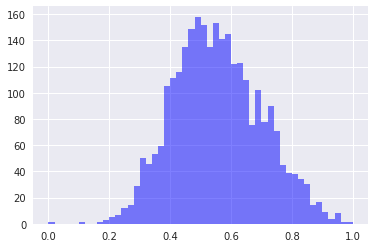

In [402]:
## Generate a function that plots the distribution of any variable in the dataset
def charter(df, variable, bins):
    
    ## select just df & variable chosen
    data_in = df.loc[:,variable]
    n_bins = bins
    
    ## plot histogram
    n, bins, patches = plt.hist(data_in, n_bins, facecolor = 'blue', alpha = 0.5)
    plt.show()
    
## Change the variable name to visualize, or take a look at original data in the same way
charter(full_data, 'AdjEM', 50)

Next, the historic game data file is processed & ultimately joined with the KenPom data. The end goal is to create a data set that appends transformed KenPom data to each game since 2010. The KenPom data will become the inputs into models created. 

Logically speaking, this process applies relevant season-summary statistics to each team in a given matchup. Conceptually, the model will determine how these season-long statistics translate to the expected scoring difference between the two teams, as well as the total number of points scored in the matchup.

In [121]:
##### STEP 2 - data processing historic game data & joining w/ KenPom to Create Team-Year Summaries #####

## End goal is to create a data set that appends transformed KenPom data to each game since 2010
## The KenPom data will become the inputs into models created

## Join Game Data with Summary Data
## First create copy for future evaluation purposes
## Create join key of team / year combination

full_data_model = full_data.copy()
full_data_model['lookup'] = full_data_model['Year'].map(str) + "_" + full_data_model['team_fix']
full_data_model.drop(['team_fix'], axis=1, inplace=True)

## Create new columns with random home/away splits
## To avoid over-predicting home team winners - happening previously
## This approach gave superior performance in the model, notably with AUC

np.random.seed(1975)
df_rand = np.random.random_sample((len(historic_game_data.index), ))
historic_game_data['rand'] = df_rand

## Create new columns with random home/away splits 
historic_game_data['team_one'] = np.where(historic_game_data['rand'] >= .5,
                                          historic_game_data['year'].map(str) + "_" + historic_game_data['Home_Team'],
                                          historic_game_data['year'].map(str) + "_" + historic_game_data['Away_Team'])
historic_game_data['team_two'] = np.where(historic_game_data['rand'] >= .5,
                                          historic_game_data['year'].map(str) + "_" + historic_game_data['Away_Team'],
                                          historic_game_data['year'].map(str) + "_" + historic_game_data['Home_Team'])

## Create home/neutral/away variable
## May be better as two binary flags
historic_game_data['loc'] = np.where(historic_game_data['tourney_game'] == 1.0, 0.0,
                                np.where(historic_game_data['team_one'] == historic_game_data['year'].map(str) + "_" + historic_game_data['Home_Team'], 1.0, -1.0
                                        )
                                    )

## Drop date variable - not used in this model, but could be of value 
historic_game_data.drop(['day'], axis = 1, inplace = True)

## Create copy of kenpom data to avoid having to change all column names after merge
full_data_model_two = full_data_model.copy()
full_data_model_two.columns = ['AdjEM_opp', 'AdjO_opp', 'AdjD_opp', 'AdjT_opp', 'Luck_opp', 'AdjEM_SOS_opp', 'OppO_opp', 'OppD_opp', 'AdjEM_NCSOS_opp', 'Year_opp', 'lookup_opp']

## Merge game data with kenpom data to append kenpom data to the game data
historic_game_data = pd.merge(historic_game_data, full_data_model, left_on = 'team_one', right_on = 'lookup')
historic_game_data = pd.merge(historic_game_data, full_data_model_two, left_on = 'team_two', right_on = 'lookup_opp')

## Create total & difference variables 
## Total represents the number of points scored in the game (sum of both teams)
## Difference represents the difference in points scored by the home & away teams.
## If the home team wins by 10, the difference variable would be 10. If the home team loses by 10, the difference variable would be -10
## difference & total will be the target variables in the final models
## Reason for the where statement is the randomizer used earlier

final_model_data = historic_game_data.copy()
final_model_data['total'] = final_model_data['Home_Score'] + final_model_data['Away_Score']
final_model_data['difference'] = np.where(historic_game_data['year'].map(str) + "_" + historic_game_data['Home_Team'] == historic_game_data['team_one'],
                                          final_model_data['Home_Score'] - final_model_data['Away_Score'],
                                          final_model_data['Away_Score'] - final_model_data['Home_Score'])
                                          
## Create copy in case we want to reference any dropped data later, and drop unnecessary variables for modeling.

final_model_all = final_model_data.copy()
final_model_all.drop(['year', 'Home_Team', 'rand', 'Away_Team', 'Home_Score', 'Away_Score', 'team_one', 'team_two', 'tourney_game', 'lookup', 'lookup_opp'], axis=1, inplace=True)

## Convert Year variables to floats
final_model_all['Year'] = final_model_all['Year'] / 1.0
final_model_all['Year_opp'] = final_model_all['Year_opp'] / 1.0

## Take a quick look at final model file to get more comfortable with the output

final_model_all.head()

,loc,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM_SOS,OppO,OppD,AdjEM_NCSOS,...,AdjD_opp,AdjT_opp,Luck_opp,AdjEM_SOS_opp,OppO_opp,OppD_opp,AdjEM_NCSOS_opp,Year_opp,total,difference
0,0.0,0.550175,0.605660,0.589806,0.428030,0.369272,0.388926,0.527919,0.718121,0.255157,...,0.502427,0.655303,0.474394,0.485906,0.588832,0.604027,0.6256,2018.0,163,-15
1,1.0,0.550175,0.605660,0.589806,0.428030,0.369272,0.388926,0.527919,0.718121,0.255157,...,0.502427,0.655303,0.474394,0.485906,0.588832,0.604027,0.6256,2018.0,170,-6
2,1.0,0.524033,0.441509,0.432039,0.405303,0.560647,0.499329,0.624365,0.624161,0.566827,...,0.502427,0.655303,0.474394,0.485906,0.588832,0.604027,0.6256,2018.0,165,3
3,-1.0,0.455005,0.492453,0.635922,0.446970,0.673854,0.452685,0.604061,0.691275,0.363945,...,0.502427,0.655303,0.474394,0.485906,0.588832,0.604027,0.6256,2018.0,148,-12
4,1.0,0.455005,0.492453,0.635922,0.446970,0.673854,0.452685,0.604061,0.691275,0.363945,...,0.502427,0.655303,0.474394,0.485906,0.588832,0.604027,0.6256,2018.0,152,-22


### Exploratory Data Analysis

The function beneath outlines two factors against one another, and is especially valuable for compairing the two target factors (absolute and distinction). In view of the structure of the dataset, since a lion's share of the watched information contains an away and home group, it has sense that the normal effect is well over 0, as home groups are bound to beat away groups in a vacuum. As demonstrated in the remarks, the nonpartisan court pointer isn't totally dependable, as it is just catching March Madness diversions, and not other unbiased court events that happen over the span of the period.

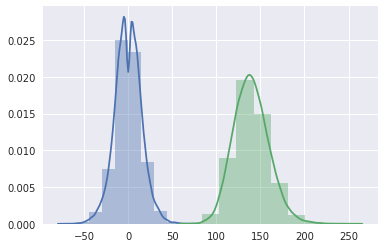

Mean of 'difference' is -0.040000000000000001 and stdev is 14.99
Mean of 'total' is 139.41999999999999 and stdev is 20.09


(None, None)

In [55]:
## EDA - Quick function to take a look at distribution of both dependent variables 

## Take a look at dependent variables

import seaborn as sns
import decimal

def dist_plotter(df, x, y, bins = 15):
    x_val = df[x].values
    y_val = df[y].values
    
    ## Generate distplot with seaborn
    
    sns.set(color_codes=True)
    sns.distplot(x_val, bins = bins)
    sns.distplot(y_val, bins = bins)
    plt.show()
    
    ## Print out summary stats for data selected
    
    meanx = round(np.mean(x_val), 2)
    stdx = round(np.std(x_val), 2)
    meany = round(np.mean(y_val), 2)
    stdy = round(np.std(y_val), 2)
    print('Mean of ' + repr(x) + ' is ' + repr(meanx) +' and stdev is ' + repr(stdx))
    print('Mean of ' + repr(y) + ' is ' + repr(meany) +' and stdev is ' + repr(stdy))

## Run Function

dist_plotter(final_model_all, 'difference', 'total', 10)

### Splitting Data into Train/Validation/Test

Next the dataset is part into preparing, approval and test sets for displaying. Note that information is part into two unique arrangements of records - an 'train' set and 'test' set. This is to make distinctive models for all out and contrast utilizing a similar split of preparing/approval/testing sets. The information is then set aside to S3 so it very well may be referenced by the Sagemaker preparing function calls. For this situation we pre-handled information inside the Sagemaker Jupyter notebook instance, yet by and by this can occur outside of Sagemaker as Sagemaker worked in calculations simply require information on S3.

In [ ]:
###### STEP 3 - SPLITTING INTO TRAINING, VALIDATION & TEST #######

## Creating 2 separate models - one to predict the total points scored in each game, another to calculate
## The expected score difference between the two teams. Using both gives you the implied score of each game

## Split into train / validation / test sets

train_data, validation_data, test_data = np.split(final_model_all.sample(frac=1, random_state=1975), [int(0.7 * len(final_model_all)), int(0.85 * len(final_model_all))])

## Reason for drop post train/test split is to ensure same dataset across different splits
## Difference models - create train, validation & test sets & drop total variable

train_data_diff = train_data.copy()
train_data_diff.drop(['total'], axis=1, inplace=True)
validation_data_diff = validation_data.copy()
validation_data_diff.drop(['total'], axis=1, inplace=True)
test_data_diff = test_data.copy()
test_data_diff.drop(['total'], axis = 1, inplace = True)

## Reorder columns
## Then move target variable to first column - how xgboost reads dataset

diff_cols = train_data_diff.columns.tolist()
diff_cols.insert(0, diff_cols.pop(diff_cols.index('difference')))
train_data_diff = train_data_diff.reindex(columns= diff_cols)
validation_data_diff = validation_data_diff.reindex(columns = diff_cols)
test_data_diff = test_data_diff.reindex(columns = diff_cols)

## Total models - Train & Validation

train_data_total = train_data.copy()
train_data_total.drop(['difference'], axis=1, inplace=True)
validation_data_total = validation_data.copy()
validation_data_total.drop(['difference'], axis=1, inplace=True)
test_data_total = test_data.copy()
test_data_total.drop(['difference'], axis = 1, inplace = True)

## Reorder columns
## Then move target variable to first column - how xgboost reads dataset

total_cols = train_data_total.columns.tolist()
total_cols.insert(0, total_cols.pop(total_cols.index('total')))
train_data_total = train_data_total.reindex(columns = total_cols)
validation_data_total = validation_data_total.reindex(columns = total_cols)
test_data_total = test_data_total.reindex(columns = total_cols)

## Save files to CSV & upload to S3
## Save locally 

train_data_total.to_csv('train_total.csv', header=False, index=False)
train_data_diff.to_csv('train_diff.csv', header=False, index=False)
validation_data_diff.to_csv('validation_diff.csv', header=False, index=False)
validation_data_total.to_csv('validation_total.csv', header=False, index=False)

## Upload to S3 

mybucketref.Object(os.path.join(prefix_diff, 'train/train.csv')).upload_file('train_diff.csv')
mybucketref.Object(os.path.join(prefix_total, 'train/train.csv')).upload_file('train_total.csv')
mybucketref.Object(os.path.join(prefix_diff, 'val/validation.csv')).upload_file('validation_diff.csv')
mybucketref.Object(os.path.join(prefix_total, 'val/validation.csv')).upload_file('validation_total.csv')


## Take a look at data from the Total Test file

test_data_total.head()

### Modeling

Let's begin the displaying procedure! <br> 

As referenced two models will be made, beginning with the 'distinction' display (the normal contrast between two groups). The rationale for making the distinction variable is what number of progressively expected focuses "group one" will score than "group two." The primary segment of the code obstruct sets the ground for displaying with Sagemaker and the base part characterizes the hyperparameters for xgboost and eventually runs the model. This procedure is then imitated for the 'all out' show (deciding the all out number of focuses scored in the amusement). When the models are finished, the examples spun up to run the models will be closed down to keep up ideal cost effectiveness.

In [78]:
###### STEP 4 - Modeling! ######### 

## Load in Sagemaker dependencies

import sagemaker
from sagemaker.predictor import csv_serializer

## Since we're training with the CSV file format, we'll create s3_inputs that our training function 
## can use as a pointer to the files in S3 which are also in CSV format

## We'll start with the difference model, then perform the exact same exercise for the total model

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/'.format(mybucket, prefix_diff), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/val/'.format(mybucket, prefix_diff), content_type='csv')

## Create variable to represent Sagemaker session

sess = sagemaker.Session()

## We need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

containers = {
                'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
                'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
                'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
                'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'
             }

## Define training parameters for Sagemaker run - this is not a large dataset, so only 1 instance count is required

xgb_diff = sagemaker.estimator.Estimator(containers[boto3.Session().region_name], ## what algorithm to use
                                    role, ## IAM role generated in first code block
                                    train_instance_count=1, 
                                    train_instance_type="ml.m4.xlarge",
                                    output_path='s3://{}/{}/output'.format(mybucket, prefix_diff), ## output destination
                                    sagemaker_session=sess)

## Define hyperparameters for modeling - feel free to adapt these!

xgb_diff.set_hyperparameters(max_depth=7,
                        eta=0.025,
                        gamma=1,
                        min_child_weight=2,
                        subsample=0.7,
                        colsample_bytree = 0.8,
                        silent=0,
                        objective='reg:linear',
                        eval_metric = 'rmse',
                        num_round=150)

## Run the training job - this should take 6-8 minutes

xgb_diff.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-03-06-22-05-19-711


.......................................................................
Arguments: train
[2018-03-06:22:11:12:INFO] Running standalone xgboost training.
[2018-03-06:22:11:12:INFO] File size need to be processed in the node: 12.82mb. Available memory size in the node: 8675.03mb
/opt/amazon/lib/python2.7/site-packages/sage_xgboost/train_helper.py:315: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(files_path, csv_file), sep=None, header=None)
[0]#011train-rmse:14.7962#011validation-rmse:14.6458
[22:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=7
[22:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=7
[1]#011train-rmse:14.6009#011validation-rmse:14.4571
[22:11:12] src/tree/updater_prune.cc:74: tree pruni

[22:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[128]#011train-rmse:9.33171#011validation-rmse:10.0794
[22:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[129]#011train-rmse:9.32725#011validation-rmse:10.0789
[22:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[130]#011train-rmse:9.32319#011validation-rmse:10.0791
[22:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[131]#011train-rmse:9.31839#011validation-rmse:10.0786
[22:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[132]#011train-rmse:9.31395#011validation-rmse:10.0784
[22:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[133]#011train-rmse:9.30975#011validation-rmse:

In [79]:
## Repeat Exact same process for the Total Model

## Modeling!

import sagemaker
from sagemaker.predictor import csv_serializer

## Since we're training with the CSV file format, we'll create s3_inputs that our training function 
## can use as a pointer to the files in S3 which are also in CSV format

## We'll start with the difference model, then perform the exact same exercise for the total model

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/'.format(mybucket, prefix_total), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/val/'.format(mybucket, prefix_total), content_type='csv')

## Create variable to represent Sagemaker session

sess = sagemaker.Session()

## We need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

containers = {
                'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
                'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
                'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
                'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'
             }

## Define training parameters for Sagemaker run - this is not a large dataset, so only 1 instance count is required

xgb_total = sagemaker.estimator.Estimator(containers[boto3.Session().region_name], ## what algorithm to use
                                    role, ## IAM role generated in first code block
                                    train_instance_count=1, 
                                    train_instance_type="ml.m4.xlarge",
                                    output_path='s3://{}/{}/output'.format(mybucket, prefix_total), ## output destination
                                    sagemaker_session=sess)

## Define the hyperparameters for the total model. Optimize these specifically for this model

xgb_total.set_hyperparameters(max_depth=7,
                        eta=0.03,
                        gamma=1,
                        min_child_weight=2,
                        subsample=0.75,
                        colsample_bytree = 0.75,
                        silent=0,
                        objective='reg:linear',
                        eval_metric = 'rmse',
                        num_round=175)

## Run the training job - this should take 7-8 minutes

xgb_total.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-03-06-22-24-36-420


..................................................................................
Arguments: train
[2018-03-06:22:31:19:INFO] Running standalone xgboost training.
[2018-03-06:22:31:19:INFO] File size need to be processed in the node: 12.85mb. Available memory size in the node: 8634.33mb
/opt/amazon/lib/python2.7/site-packages/sage_xgboost/train_helper.py:315: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(files_path, csv_file), sep=None, header=None)
[22:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[0]#011train-rmse:136.249#011validation-rmse:136.332
[22:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[1]#011train-rmse:132.231#011validation-rmse:132.309
[22:31:20] src/tree/updater_prune.cc:74: t

[22:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=7
[144]#011train-rmse:15.0428#011validation-rmse:16.0612
[22:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=7
[145]#011train-rmse:15.0291#011validation-rmse:16.0568
[22:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=7
[146]#011train-rmse:15.0145#011validation-rmse:16.049
[22:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[147]#011train-rmse:15.0031#011validation-rmse:16.0409
[22:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=7
[148]#011train-rmse:14.9908#011validation-rmse:16.0362
[22:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=7
[149]#011train-rmse:14.9783#011validation-rmse:1

### Endpoint Hosting

Since the models are made - how about we standup the endpoints that will be fit for foreseeing results on new information. Not at all like the occurrences running the models, these endpoints will run persistently, so it's imperative to make sure to close them down when they are never again significant! The endpoints influence a littler occurrence type, as the derivations created in this utilization case are lightweight. <br> 

This is the place Sagemaker truly sparkles. With only two lines of code we currently have two endpoints fit for producing expectations with a straightforward POST ask.

In [80]:
###### STEP 5 - Generate predictions from the endpoint ######### 

## Set up endpoint - diff model

en_diff = 'difference-cbb-ep'

xgb_predictor_diff = xgb_diff.deploy(initial_instance_count=1,
                                     instance_type='ml.t2.medium', ## Using smallest instance type in this case
                                     endpoint_name=en_diff)

INFO:sagemaker:Creating model with name: xgboost-2018-03-06-22-33-32-917
INFO:sagemaker:Creating endpoint with name difference-cbb-ep


------------------------------------------------------------------------------------------------------------!

In [82]:
## Set up endpoint - repeat process for total model

en_total = 'total-cbb-ep'

xgb_predictor_total = xgb_total.deploy(initial_instance_count=1, 
                                       instance_type='ml.t2.medium', 
                                       endpoint_name=en_total)


INFO:sagemaker:Creating model with name: xgboost-2018-03-06-22-45-47-233
INFO:sagemaker:Creating endpoint with name total-cbb-ep


------------------------------------------------------------------------------------------------------------------------!

### Model Performance Evaluation

Let's assess the execution of the test set on both the distinction and all out models. The code obstruct underneath takes the information held out in the test set and produces expectations against the endpoints made. We at that point make a few factors for the motivations behind assessment, talked about in the following area.

In [102]:
## Serialize data & create predictions from test set
## Serialization is required to ensure data is in proper format for inference

xgb_predictor_diff.content_type = 'text/csv'
xgb_predictor_diff.serializer = csv_serializer
xgb_predictor_diff.deserializer = None

## Function to chunk down test set into smaller increments

def predict(data, model, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

## Generate predictions on the test set for the difference models

predictions_diff = predict(test_data_diff.as_matrix()[:, 1:], xgb_predictor_diff) 

## Replicate the same process for the Total model

## Serialize data & creation predictions from test set

xgb_predictor_total.content_type = 'text/csv'
xgb_predictor_total.serializer = csv_serializer
xgb_predictor_total.deserializer = None

## Total Predictions

predictions_total = predict(test_data_total.as_matrix()[:,1:], xgb_predictor_total) 

## Evaluation create variables for difference model evaluation

test_data_diff['preds'] = predictions_diff
test_data_diff['act_residual'] = test_data_diff['difference'] - test_data_diff['preds']
test_data_diff['abs_residual'] = abs(test_data_diff['difference'] - test_data_diff['preds'])
test_data_diff['sq_error'] = (test_data_diff['difference'] - test_data_diff['preds']) ** 2
test_data_diff['home_team_cover'] = np.where(test_data_diff['act_residual'] > 0, 1, 0)
test_data_diff['act_binary'] = np.where(test_data_diff['difference'] > 0, 1, 0)
test_data_diff['pred_binary'] = np.where(test_data_diff['preds'] > 0, 1, 0)
test_data_diff['right'] = np.where(np.sign(test_data_diff['preds']) == np.sign(test_data_diff['difference']), 1, 0)

## Same for total model - not all relevant, because there is no concept of "winning"

test_data_total['preds'] = predictions_total
test_data_total['act_residual'] = test_data_total['total'] - test_data_total['preds']
test_data_total['abs_residual'] = abs(test_data_total['total'] - test_data_total['preds'])
test_data_total['sq_error'] = (test_data_total['total'] - test_data_total['preds']) ** 2

## Take a look at difference file

test_data_diff.head()

,difference,loc,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM_SOS,OppO,OppD,...,AdjEM_NCSOS_opp,Year_opp,preds,act_residual,abs_residual,sq_error,home_team_cover,act_binary,pred_binary,right
17634,2,1.0,0.567161,0.530189,0.461538,0.323420,0.237197,0.430537,0.538071,0.644295,...,0.451950,2015.0,1.610676,0.389324,0.389324,0.151573,1,1,1,1
6667,-6,1.0,0.384893,0.358491,0.608173,0.483271,0.380054,0.414094,0.563452,0.711409,...,0.425947,2017.0,-1.091461,-4.908539,4.908539,24.093753,0,0,0,1
16056,-19,-1.0,0.381159,0.415094,0.685096,0.438662,0.444744,0.244631,0.365482,0.791946,...,0.626343,2016.0,-6.748634,-12.251366,12.251366,150.095972,0,0,0,1
35972,-23,-1.0,0.564510,0.571698,0.521635,0.434944,0.719677,0.616779,0.538071,0.275168,...,0.492651,2012.0,-12.391322,-10.608678,10.608678,112.544046,0,0,0,1
216,1,-1.0,0.424648,0.460377,0.658654,0.743494,0.606469,0.086242,0.258883,0.966443,...,0.526569,2018.0,0.208521,0.791479,0.791479,0.626440,1,1,1,1


In the segment underneath we'll assess the execution of the model on the test set with the expectations created in the past advance. 

To do this, we'll influence the factors we just made and utilize the equivalent dist_plotter capacity to picture the residuals of the two models. It shows up the blunder for both is ordinarily appropriated. 

Next, a perplexity network is worked to perceive how precisely wins and misfortunes are anticipated. For this situation, the general exactness and AUC was 77.7%. In testing, the randomization of home and away had positive effect on AUC execution. 

As talked about in the presentation, the exactness is likely swelled because of predisposition presented by utilizing end-of-season information to foresee amusements prior in the season. In a perfect world, this information would be accessible in a point-in-time group, however amid the formation of this note pad that information was not accessible. In testing the effect of this inclination with accessible information it has demonstrated to have a negative exhibition on by and large model exactness (74% versus 72% in February/March 2018), yet at the same time gives a strong benchmark. 

At long last we investigate the RMSE and R squared for both the distinction and absolute models. 

The general execution measurements you produce will be unique in relation to these figures dependent on various preparing and testing parts, more information to assess etc..., yet without huge changes the numbers ought to be sensibly near these figures.

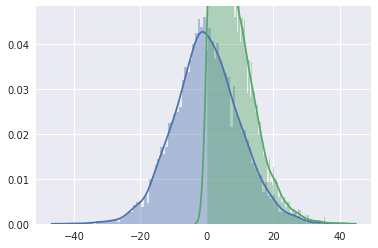

Mean of 'act_residual' is 0.0 and stdev is 9.9499999999999993
Mean of 'abs_residual' is 7.7999999999999998 and stdev is 6.1600000000000001


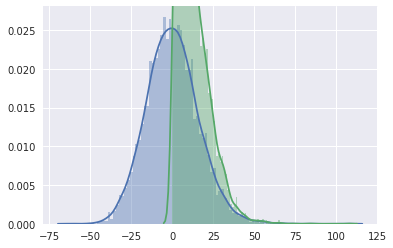

Mean of 'act_residual' is 0.19 and stdev is 15.9
Mean of 'abs_residual' is 12.5 and stdev is 9.8399999999999999


(None, None)

In [86]:
####### STEP 6 - MODEL EVALUATION #######

## Add in RMSE 
dist_plotter(test_data_diff, 'act_residual', 'abs_residual', 100)
dist_plotter(test_data_total, 'act_residual', 'abs_residual', 100)

[[2496  738]
 [ 706 2550]]


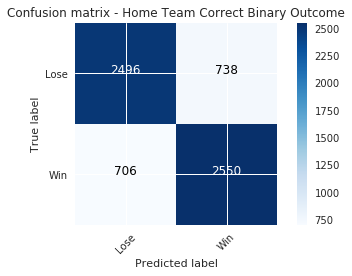

Accuracy is 0.77749999999999997


In [103]:
## Create confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import itertools
c_mat = confusion_matrix(test_data_diff['act_binary'], test_data_diff['pred_binary']) ## Predicted vs. actual outcome
accuracy = round(accuracy_score(test_data_diff['act_binary'], test_data_diff['pred_binary']) ,4) ## Overall accuracy
class_names = ['Lose', 'Win'] ## Different class names

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Blues):                                 
                                              
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(c_mat, classes=class_names, 
                          title='Confusion matrix - Home Team Correct Binary Outcome')
plt.show()
print('Accuracy is ' + repr(accuracy))

In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Calculate RMSE & R2 on the test set - difference model

print(round((mean_squared_error(test_data_diff['difference'], test_data_diff['preds']) ** .5) ,2)) ## RMSE
print(round(r2_score(test_data_diff['difference'], test_data_diff['preds']), 2)) ## R2

9.95
0.57


In [89]:
## Calculate RMSE & R2 on the test set - total model

print(round((mean_squared_error(test_data_total['total'], test_data_total['preds']) ** .5) ,2)) ## RMSE
print(round(r2_score(test_data_total['total'], test_data_total['preds']), 2)) ## R2

15.9
0.38


In the following three cells we'll pull down the model records from S3 and view the element significance of the models made. Highlight significance can be freely deciphered as how powerful each element is in creating expectations. Since the xgboost calculation is fit for making complex non-straight connections, these can't be translated in a direct manner with the objective factors. 

The main graph demonstrates the element effect of the distinction display, while the second demonstrates the component effect of the complete model. The numbers on the Y hub are the request of the segments in the dataset utilized for forecast (beginning from 1). "2" and "12" speak to the Adj_EM for the two groups and are the most compelling factors in the distinction show, which means the general season-long productivity of the two groups is the most essential indicator in deciding the contrast between two groups in a given diversion, which is legitimate. These factors are considerably less critical in the all out model, which additionally bodes well.

In [43]:
## Install a couple packages that will allow us to generate predictions without creating an endpoint
## Once this is run once, it does not need to be run again

import sys
!{sys.executable} -m pip install joblib
!{sys.executable} -m pip install xgboost

    100% |████████████████████████████████| 184kB 4.1MB/s ta 0:00:01
    100% |████████████████████████████████| 460kB 2.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ca/b3/02/d44d5e12c5c1eecff4a822555bac96b182551cd5e13c4795f6
Successfully built xgboost


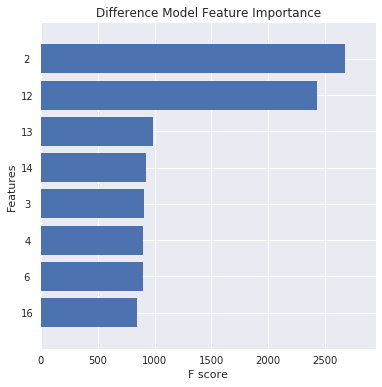

In [131]:
## Update the line below with the location of your model file within your S3 Bucket

xgboost_output_diff = #'sagemaker_diff/output/{model_file_location}/output/model.tar.gz'

## Pull down the model file locally

mybucketref.download_file(xgboost_output_diff, 'diff_model.tar.gz')

import tarfile
import joblib
import xgboost as xgb

## Unpack model file

tar = tarfile.open("diff_model.tar.gz", "r:gz")
for member in tar.getmembers():
     f = tar.extractfile(member)
     if f is not None:
         content = f.read()
tar.extractall()
fil = open('xgboost-model', 'rb')

## Load model file back into generate predictions & view feature importance

xgb_local_diff = joblib.load(fil)

## Close

fil.close()

## Chart variable importance

fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xgb_local_diff, max_num_features=8, height=0.8, ax=ax, show_values = False)
plt.title('Difference Model Feature Importance')
plt.show()

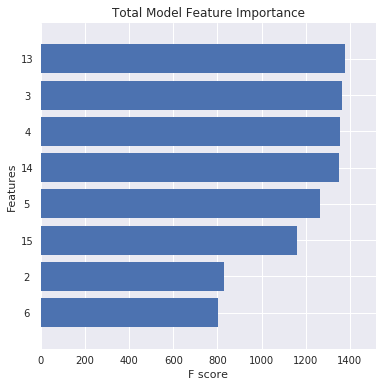

In [133]:
## Update the line below with the location of your model file within your S3 Bucket

xgboost_output_total = #'sagemaker_total/output/{model_file_location}/output/model.tar.gz'

## Pull down the model file locally

mybucketref.download_file(xgboost_output_total, 'total_model.tar.gz')

import tarfile
import joblib

## Unpack model file

tar = tarfile.open("total_model.tar.gz", "r:gz")
for member in tar.getmembers():
     f = tar.extractfile(member)
     if f is not None:
         content = f.read()
tar.extractall()
fil = open('xgboost-model', 'rb')

## Load model file back into generate predictions & view feature importance

xgb_local_total = joblib.load(fil)

## Close

fil.close()

## Chart variable importance

fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xgb_local_total, max_num_features=8, height=0.8, ax=ax, show_values = False)
plt.title('Total Model Feature Importance')
plt.show()

### Win Probability Derivative Model

Finally, how about we investigate how our distinction forecasts are identified with a group's probability of really winning an game. The graph demonstrates the watched winning rate from the test set dependent on the anticipated contrast (binned by whole number) between two groups. For all intents and purposes, when the anticipated distinction for a group is 10 in the test set they win somewhat less than 90% of the time. 

The sigmoid bend fits the circulation great - unmistakably spread expectations don't have a direct association with result, as groups that are anticipated to win by a considerable amount in all respects once in a while lose (and visa versa for groups anticipated to lose).

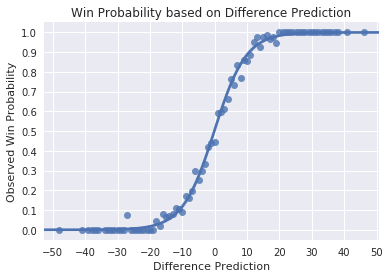

In [105]:
## Error Eval - Figure out probability of winning by predicted difference

test_data_diff['preds_2'] = test_data_diff['preds'].round()

summ = test_data_diff.groupby('preds_2')['act_binary'].agg(['sum','count']).reset_index()
summ['win_prob'] = summ['sum'] / summ['count']

def eval_plotter(df, x, y):
    x_val = df[x].values
    y_val = df[y].values
    
    ## Generate distplot with seaborn
    
    #sns.set(color_codes=True)
    p = sns.regplot(x=x_val, y=y_val, data = df, logistic = True)
    plt.title('Win Probability based on Difference Prediction')
    plt.xlabel('Difference Prediction')
    plt.xticks(np.arange(-50, 60, 10))
    plt.ylabel('Observed Win Probability')
    plt.yticks(np.arange(0, 1.1, .1))
    plt.show(p)
    
    ## Print out summary stats for data selected
    
    return df

df = eval_plotter(summ, 'preds_2', 'win_prob')

Based on this relationship, a simple logistic regression model was created using the test set with the predictor being the difference prediction, and target as whether the team won or lost. The practical output is the expected win probability based on the expected difference between the two teams. The function in the final code block takes an expected difference & converts it into expected probability of winning. In the example shown, if "team one" is projected to win by 20 should win 98.1% of the time.

In [106]:
## Logistic regression to find probability of wins 

from sklearn.linear_model import LogisticRegression

x_val = test_data_diff['preds'].values.reshape(-1, 1)
y_val = test_data_diff['act_binary'].values

## Create simple logistic regression model with spread predictions as the predictor & win/loss outcome as the target

model = LogisticRegression()
model = model.fit(x_val, y_val)

## Save & print out model coeffcients

mc = model.coef_
inter = model.intercept_
print('intercept: ' ,inter, 'pred_coefficient: ', mc)

intercept:  [-0.01456929] pred_coefficient:  [[ 0.19774715]]


In [196]:
## Function to convert spread into probability based on logistic regression model

def prob_converter(spread):
    val = np.exp(inter + mc * spread) / (1 + np.exp(inter + mc * spread))
    val = val.round(4) * 100
    return(val)

prob_converter(20)

array([[ 98.09]])

AUC is 0.86109999999999998


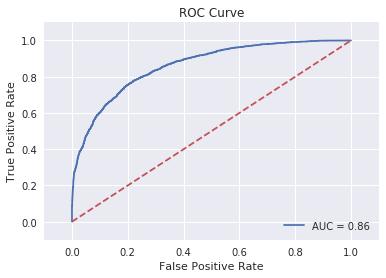

In [118]:
## Finally convert to AUC

from sklearn import metrics

test_data_diff['pred_val'] = np.exp(-0.01456929 + 0.19774715 * test_data_diff['preds'])/ (1 + np.exp(-0.01456929 + 0.19774715 * test_data_diff['preds']))
auc = round(roc_auc_score(test_data_diff['act_binary'], test_data_diff['pred_val']), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(test_data_diff['act_binary'], test_data_diff['pred_val'])

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The final output of this work is the website below - it leverages the endpoints to generate new predictions on the total & difference models, and uses those predictions to generate a predicted probability of winning both for today's games, as well as any hypothetical matchup of teams since 2011. Take a look at the site below to test it out!

https://criviere.github.io/ncaa_camilo_armando/
